# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100

## "Tractable model"

In [3]:
SIGMA = 0.05
def model(z):
    z = (z-0.5)*6
    mu = z[:2]
    s = z[2:4]
    rho = np.tanh(z[4])
    Sigma = np.array([[s[0]**2, rho*s[0]*s[1]], [rho*s[0]*s[1], s[1]**2]])
    x = np.random.multivariate_normal(mu, Sigma, size = 4)
    return x.flatten()

z0 = np.array([0.7, -2.9, -1.0, -0.9, 0.6])/6+0.5
zdim = len(z0)
x0 = model(z0)

ds = swyft.DataStoreZarr()
ds.init(zdim = zdim, xdim = x0.shape)

head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


## Torus model

In [4]:
def model(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noisemodel(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = model(z0)  # Using Asimov data

ds = swyft.DataStoreZarr()
ds.init(zdim = zdim, xdim = x0.shape)

head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


## Inference

In [5]:
sw_list = []

In [6]:
for i_round, nsamples in enumerate([5000, 5000, 5000, 20000]):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = zdim, device = DEVICE, head = head, noisemodel = noisemodel, datastore = ds, nsamples = nsamples, parent = parent)
    sw_list.append(sw)

    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)

    sw.train1d(max_epochs = MAX_EPOCHS, nbatch = 128, lr_schedule = [1e-3, 1e-4])

Constrained posterior area: 1.0
Adding 10016 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 6
Validation losses: [4.659455060958862, 4.251551389694214, 4.1147541999816895, 4.182873964309692, 4.182709336280823, 4.355978727340698]
LR iteration 1
Total epochs: 6
Validation losses: [4.05121922492981, 4.2098870277404785, 4.050053536891937, 4.070759296417236, 4.124733567237854, 4.20506739616394]
Constrained posterior area: 0.2750275
Adding 7441 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 15
Validation losses: [5.809724926948547, 5.6637667417526245, 5.569413900375366, 5.566658616065979, 5.509105920791626, 5.485372185707092, 5.359027624130249, 5.305042505264282, 5.368742108345032, 5.263190388679504, 5.397286772727966, 5.152620434761047, 5.309216141700745, 5.324199199676514, 5.212735295295715]
LR iteration 1
Total epochs: 6
Validation losses: [5.148987889289856, 5.176292657852173, 5.066724896430969, 5.1962807178497314, 5.200626611709595, 5.19

40773

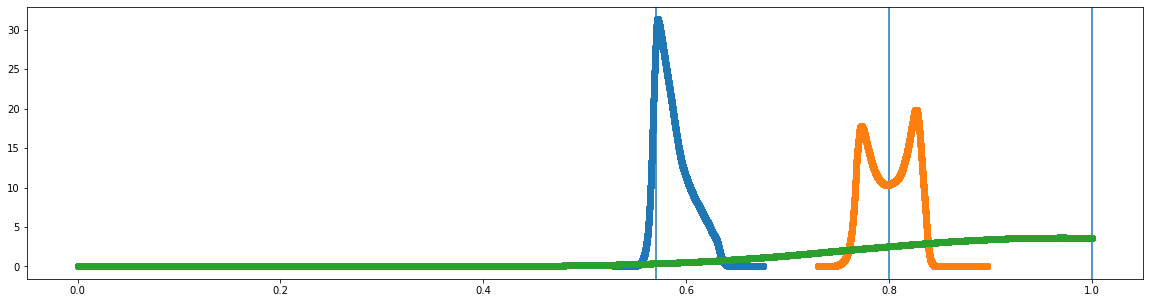

In [7]:
plt.figure(figsize=(20, 5))
for i in range(zdim):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.plot(z, p, marker='o')
#plt.gca().set_yscale('log')
len(ds)

In [ ]:
sw_list[-1].trainNd([[0, 1], [1, 2], [0, 2]], max_epochs = MAX_EPOCHS, nbatch = 128, lr_schedule = [1e-4])

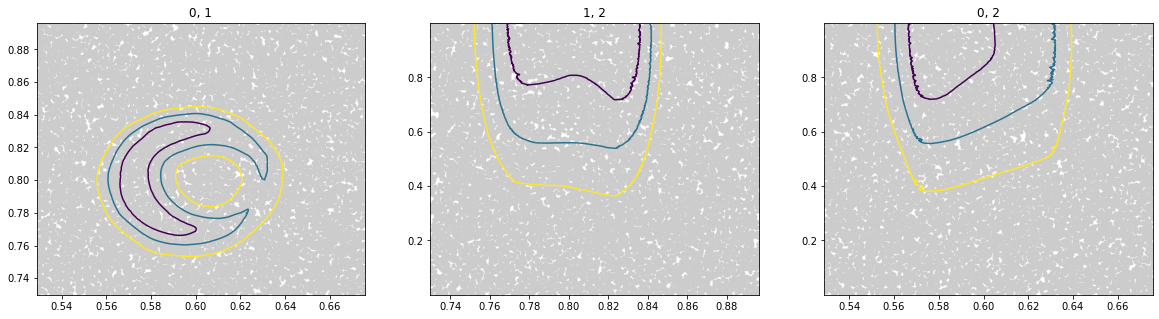

In [21]:
c = 1
plt.figure(figsize=(20, 5))
for i, j in [[0, 1], [1, 2], [0, 2]]:
    zgrid, lnLgrid = sw_list[-1].posterior([i, j])
    plt.subplot(1, 3, c)
    c+=1
    plt.title("%i, %i"%(i, j))
    plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
    max_lnL = lnLgrid[:].max()
    plt.tricontour(zgrid[:,0], zgrid[:,1], (-lnLgrid+max_lnL)*2, levels = [1, 4, 9])

In [13]:
z = np.array(ds.z)

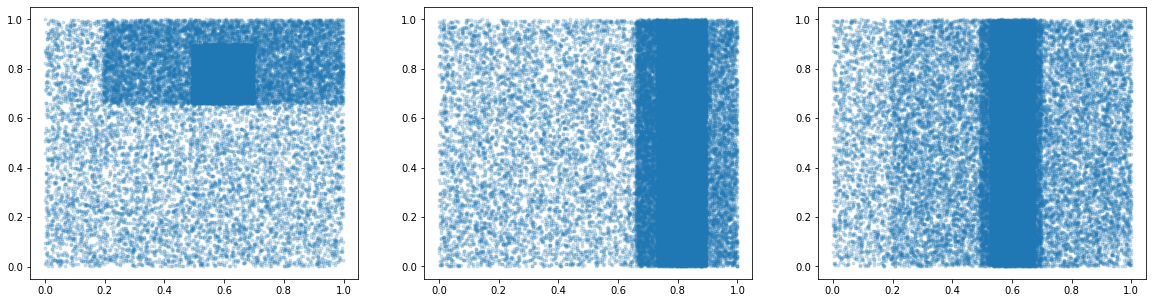

In [14]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
plt.scatter(z[:,0], z[:,1], marker='.', alpha = 0.2)
plt.subplot(132)
plt.scatter(z[:,1], z[:,2], marker='.', alpha = 0.2)
plt.subplot(133)
plt.scatter(z[:,0], z[:,2], marker='.', alpha = 0.2)